<a href="https://colab.research.google.com/github/PosgradoMNA/actividades-de-aprendizaje-dsercam/blob/main/RetoFinal/RetoFinal_Avance1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**<font color="darkblue">Reto: Actividad Final</font>**
##**<font color="darkorange">  Regresiones y K means</font>**

###**Maestría en Inteligencia Artificial Aplicada**
###**Curso: Ciencia y analítica de datos**
####**Tecnológico de Monterrey**
#####**Prof: María de la Paz Rico Fernández**

###**<font color="darkgray">Nombre del estudiante: Dante Rodrigo Serna Camarillo</font>**
###**<font color="darkgray">Matrícula: A01182676</font>**


## Imports and installs

In [84]:

! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [201]:
!pip install folium matplotlib mapclassify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [85]:
import pandas as pd
import numpy as np
from shapely.geometry import Point # para definir cooredans que puedan ser usadas con geopy
import geopandas as gpd #para graficar en mapa
import matplotlib.pyplot as plt

## Carga de shape files para mexico

Obtenemos los shape files de Mexico, disponibles en un zip dentro del repo. Realizamos un unzip para cargar los datos en nuestro enterno de google colab.

In [86]:
!wget https://github.com/PosgradoMNA/actividades-de-aprendizaje-dsercam/raw/main/RetoFinal/mapa_mexico/mapa_mexico.zip
!unzip /content/mapa_mexico.zip

--2022-11-15 04:58:10--  https://github.com/PosgradoMNA/actividades-de-aprendizaje-dsercam/raw/main/RetoFinal/mapa_mexico/mapa_mexico.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/PosgradoMNA/actividades-de-aprendizaje-dsercam/main/RetoFinal/mapa_mexico/mapa_mexico.zip [following]
--2022-11-15 04:58:10--  https://raw.githubusercontent.com/PosgradoMNA/actividades-de-aprendizaje-dsercam/main/RetoFinal/mapa_mexico/mapa_mexico.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11342120 (11M) [application/zip]
Saving to: ‘mapa_mexico.zip.1’

mapa_mexico.zip.1   100%[===================>]  10.8

Leer el shape file con geopandas.

In [172]:
mx = gpd.read_file('mapa_mexico/')\
        .set_index('CLAVE')\
        #.to_crs(epsg=4485)
mx.head()

,NOM_MUN,NOMEDO,CVE_EDO,CVE_MUNI,Area,geometry
CLAVE,,,,,,
02004,Tijuana,Baja California,02,004,1122.661145,"POLYGON ((-117.09481 32.41141, -117.09481 32.4..."
02003,Tecate,Baja California,02,003,3670.991923,"POLYGON ((-116.73791 32.56703, -116.65926 32.5..."
02002,Mexicali,Baja California,02,002,13119.275713,"POLYGON ((-115.81505 32.64088, -115.70466 32.6..."
02005,Playas de Rosarito,Baja California,02,005,517.120801,"POLYGON ((-117.06254 32.34436, -117.06276 32.3..."
26055,San Luis Rio Colorado,Sonora,26,055,9033.770278,"POLYGON ((-114.96166 32.36465, -114.96239 32.3..."


## Fetch de data sets

In [115]:
#Permalinks a nuestros CSVs
csvAguasSubterraneas  = "https://raw.githubusercontent.com/PosgradoMNA/actividades-de-aprendizaje-dsercam/main/RetoFinal/Datos_de_calidad_del_agua_de_sitios_de_monitoreo_de_aguas_subterraneas_2020.csv"
csvAguasSuperficiales = "https://raw.githubusercontent.com/PosgradoMNA/actividades-de-aprendizaje-dsercam/main/RetoFinal/Datos_de_calidad_del_agua_de_sitios_de_monitoreo_de_aguas_superficiales_2020.csv"


In [116]:
#Config para ver todas las columnas de los dataframes
pd.set_option('display.max_columns', None)

In [117]:
#Fetch de datos
dfUnprocessedSubterraneas  = pd.read_csv(csvAguasSubterraneas, skipinitialspace=True, skip_blank_lines=True, encoding = 'cp1252')
dfUnprocessedSuperficiales = pd.read_csv(csvAguasSuperficiales,  skipinitialspace=True, skip_blank_lines=True, encoding = 'cp1252')


In [118]:
print('--------'*10)
print("Dimensiones DataFrame aguas superficiales (sin procesar): ", dfUnprocessedSuperficiales.shape)
print("Dimensiones DataFrame aguas subterraneas (sin procesar): ", dfUnprocessedSubterraneas.shape)
print('--------'*10)

--------------------------------------------------------------------------------
Dimensiones DataFrame aguas superficiales (sin procesar):  (4141, 55)
Dimensiones DataFrame aguas subterraneas (sin procesar):  (1068, 57)
--------------------------------------------------------------------------------


## Preprocesamiento

In [173]:
print('Preview Aguas subterraneas:')
dfUnprocessedSubterraneas.head(5)

Preview Aguas subterraneas:


,CLAVE,SITIO,ORGANISMO_DE_CUENCA,ESTADO,MUNICIPIO,ACUIFERO,SUBTIPO,LONGITUD,LATITUD,PERIODO,ALC_mg/L,CALIDAD_ALC,CONDUCT_mS/cm,CALIDAD_CONDUC,SDT_mg/L,SDT_M_mg/L,CALIDAD_SDT_ra,CALIDAD_SDT_salin,FLUORUROS_mg/L,CALIDAD_FLUO,DUR_mg/L,CALIDAD_DUR,COLI_FEC_NMP/100_mL,CALIDAD_COLI_FEC,N_NO3_mg/L,CALIDAD_N_NO3,AS_TOT_mg/L,CALIDAD_AS,CD_TOT_mg/L,CALIDAD_CD,CR_TOT_mg/L,CALIDAD_CR,HG_TOT_mg/L,CALIDAD_HG,PB_TOT_mg/L,CALIDAD_PB,MN_TOT_mg/L,CALIDAD_MN,FE_TOT_mg/L,CALIDAD_FE,SEMAFORO,CONTAMINANTES,CUMPLE_CON_ALC,CUMPLE_CON_COND,CUMPLE_CON_SDT_ra,CUMPLE_CON_SDT_salin,CUMPLE_CON_FLUO,CUMPLE_CON_DUR,CUMPLE_CON_CF,CUMPLE_CON_NO3,CUMPLE_CON_AS,CUMPLE_CON_CD,CUMPLE_CON_CR,CUMPLE_CON_HG,CUMPLE_CON_PB,CUMPLE_CON_MN,CUMPLE_CON_FE
0,DLAGU6,POZO SAN GIL,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,ASIENTOS,VALLE DE CHICALOTE,POZO,-102.02210,22.20887,2020,229.990,Alta,940.0,Permisible para riego,NaN,603.6,Cultivos sensibles,Potable - Dulce,0.9766,Potable - Optima,213.732,Potable - Dura,<1.1,Potable - Excelente,4.184656,Potable - Excelente,0.0161,Apta como FAAP,<0.003,Potable - Excelente,<0.005,Potable - Excelente,<0.0005,Potable - Excelente,<0.005,Potable - Excelente,<0.0015,Potable - Excelente,0.0891,Potable - Excelente,Verde,NaN,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
1,DLAGU6516,POZO R013 CAÑADA HONDA,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,AGUASCALIENTES,VALLE DE CHICALOTE,POZO,-102.20075,21.99958,2020,231.990,Alta,608.0,Buena para riego,NaN,445.4,Excelente para riego,Potable - Dulce,0.9298,Potable - Optima,185.0514,Potable - Dura,<1.1,Potable - Excelente,5.75011,Potable - Buena calidad,0.0134,Apta como FAAP,<0.003,Potable - Excelente,<0.005,Potable - Excelente,<0.0005,Potable - Excelente,<0.005,Potable - Excelente,<0.0015,Potable - Excelente,<0.025,Potable - Excelente,Verde,NaN,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
2,DLAGU7,POZO COSIO,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,COSIO,VALLE DE AGUASCALIENTES,POZO,-102.28801,22.36685,2020,204.920,Alta,532.0,Buena para riego,NaN,342,Excelente para riego,Potable - Dulce,1.8045,Alta,120.719,Potable - Dura,<1.1,Potable - Excelente,1.449803,Potable - Excelente,0.037,No apta como FAAP,<0.003,Potable - Excelente,<0.005,Potable - Excelente,<0.0005,Potable - Excelente,<0.005,Potable - Excelente,<0.0015,Potable - Excelente,<0.025,Potable - Excelente,Rojo,"FLUO,AS,",SI,SI,SI,SI,NO,SI,SI,SI,NO,SI,SI,SI,SI,SI,SI
3,DLAGU9,POZO EL SALITRILLO,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,RINCON DE ROMOS,VALLE DE AGUASCALIENTES,POZO,-102.29449,22.18435,2020,327.000,Alta,686.0,Buena para riego,NaN,478.6,Excelente para riego,Potable - Dulce,1.1229,Potable - Optima,199.879,Potable - Dura,<1.1,Potable - Excelente,1.258597,Potable - Excelente,0.0154,Apta como FAAP,<0.003,Potable - Excelente,0.005,Potable - Excelente,<0.0005,Potable - Excelente,<0.005,Potable - Excelente,<0.0015,Potable - Excelente,<0.025,Potable - Excelente,Verde,NaN,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
4,DLBAJ107,RANCHO EL TECOLOTE,PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LA PAZ,TODOS SANTOS,POZO,-110.24480,23.45138,2020,309.885,Alta,1841.0,Permisible para riego,NaN,1179,Cultivos con manejo especial,Ligeramente salobres,0.2343,Baja,476.9872,Potable - Dura,291,Aceptable,15.672251,No apta como FAAP,<0.01,Potable - Excelente,<0.003,Potable - Excelente,<0.005,Potable - Excelente,<0.0005,Potable - Excelente,<0.005,Potable - Excelente,<0.0015,Potable - Excelente,<0.025,Potable - Excelente,Rojo,"NO3,",SI,SI,SI,SI,SI,SI,SI,NO,SI,SI,SI,SI,SI,SI,SI


In [174]:
print('Preview Aguas Superficiales:')
dfUnprocessedSuperficiales.head(5)

Preview Aguas Superficiales:


,CLAVE,SITIO,ORGANISMO_DE_CUENCA,ESTADO,MUNICIPIO,CUENCA,CUERPO DE AGUA,TIPO,SUBTIPO,LONGITUD,LATITUD,PERIODO,DBO_mg/L,CALIDAD_DBO,DQO_mg/L,CALIDAD_DQO,SST_mg/L,CALIDAD_SST,COLI_FEC_NMP_100mL,CALIDAD_COLI_FEC,E_COLI_NMP_100mL,CALIDAD_E_COLI,ENTEROC_NMP_100mL,CALIDAD_ENTEROC,OD_PORC,CALIDAD_OD_PORC,OD_PORC_SUP,CALIDAD_OD_PORC_SUP,OD_PORC_MED,CALIDAD_OD_PORC_MED,OD_PORC_FON,CALIDAD_OD_PORC_FON,TOX_D_48_UT,CALIDAD_TOX_D_48,TOX_V_15_UT,CALIDAD_TOX_V_15,TOX_D_48_SUP_UT,CALIDAD TOX_D_48_SUP,TOX_D_48_FON_UT,CALIDAD_TOX_D_48_FON,TOX_FIS_SUP_15_UT,CALIDAD_TOX_FIS_SUP_15,TOX_FIS_FON_15_UT,CALIDAD_TOX_FIS_FON_15,SEMAFORO,CONTAMINANTES,CUMPLE_CON_DBO,CUMPLE_CON_DQO,CUMPLE_CON_SST,CUMPLE_CON_CF,CUMPLE_CON_E_COLI,CUMPLE_CON_ENTEROC,CUMPLE_CON_OD,CUMPLE_CON_TOX,GRUPO
0,DLAGU8,PRESA EL SAUCILLO 100M AGUAS ARRIBA DE LA CORTINA,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,RINCON DE ROMOS,RIO SAN PEDRO,PRESA EL SAUCILLO,LENTICO,PRESA,-102.33911,22.24730,2020.0,6,Buena calidad,54.08,Contaminada,13.75,Excelente,1162,Contaminada,98,Excelente,NaN,NaN,NaN,NaN,46.8,Aceptable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<1,No Toxico,NaN,NaN,<1,No Toxico,NaN,NaN,Rojo,"DQO,CF,",SI,NO,SI,NO,SI,ND,SI,SI,LENTICO
1,DLBAJ100,"LOS CABOS SEG 22, 2 ISA10B",PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN JOSE DEL CABO,OCEANO PACIFICO,COSTERO,OCEANO-MAR,-109.84290,22.90473,2020.0,NaN,NaN,NaN,NaN,<10,Excelente,NaN,NaN,NaN,NaN,20,Excelente,NaN,NaN,92,Excelente,95.4,Excelente,92.2,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<1,No Toxico,NaN,NaN,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
2,DLBAJ101,"LOS CABOS SEG 22, 1 ISA10B",PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN LUCAS,OCEANO PACIFICO,COSTERO,OCEANO-MAR,-109.86442,22.89880,2020.0,NaN,NaN,NaN,NaN,<10,Excelente,NaN,NaN,NaN,NaN,<3,Excelente,NaN,NaN,92,Excelente,95.4,Excelente,92.2,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<1,No Toxico,NaN,NaN,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
3,DLBAJ102,LOS CABOS 3,PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN LUCAS,BAHIA SAN LUCAS,COSTERO,BAHIA,-109.88604,22.89609,2020.0,NaN,NaN,NaN,NaN,13.9667,Excelente,NaN,NaN,NaN,NaN,<3,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,86.7,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<1,No Toxico,NaN,NaN,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
4,DLBAJ103,LOS CABOS 1,PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN LUCAS,BAHIA SAN LUCAS,COSTERO,BAHIA,-109.89657,22.87694,2020.0,NaN,NaN,NaN,NaN,<10,Excelente,NaN,NaN,NaN,NaN,30,Excelente,NaN,NaN,96.2,Excelente,95.9,Excelente,95.5,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<1,No Toxico,NaN,NaN,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO


In [175]:
#Nuestro data set tiene datos faltanates
dfUnprocessedSuperficiales.isnull().values.any()

True

In [176]:
#Informacion sobre nuestra varaible de salida:
missingOutcome = dfUnprocessedSuperficiales['SEMAFORO'].isna().sum()
totalRecords   = dfUnprocessedSuperficiales.shape[0]

print('# de Registros sin valor en variable de salida: :', missingOutcome ,'(', round(((missingOutcome/totalRecords)*100),2),'%)')
print('# de Registros por categorizacion en semaforo:\n\n',dfUnprocessedSuperficiales.SEMAFORO.value_counts())

# de Registros sin valor en variable de salida: : 648 ( 15.65 %)
# de Registros por categorizacion en semaforo:

 Verde       1267
Amarillo    1135
Rojo        1091
Name: SEMAFORO, dtype: int64


In [177]:
#Como primer paso vamos a generar una copia de nuestro dataset sin considerar los registros que no tienen valor de salida, pues no nos sirven para entrenar el algoritmo ni para validarlo.
dfForCleansingSuperficiales = dfUnprocessedSuperficiales.copy()
dfForCleansingSuperficiales = dfForCleansingSuperficiales[dfForCleansingSuperficiales['SEMAFORO'].notna()]
dfForCleansingSuperficiales.shape

(3493, 55)

In [178]:
distribution = pd.DataFrame(dfForCleansingSuperficiales.SEMAFORO.value_counts())
totalRecords = distribution.sum()
distribution['DISTRIBUTION'] = distribution/totalRecords
distribution['SEMAFORO'] = distribution.index
distribution = distribution.reset_index(drop=True)
print(' --- DISTIRBUCION DE CLASES ---')
distribution

 --- DISTIRBUCION DE CLASES ---


,SEMAFORO,DISTRIBUTION
0,Verde,0.362725
1,Amarillo,0.324936
2,Rojo,0.312339


In [ ]:
#dfMissingCuerpoDeAgua = dfForCleansingSuperficiales[dfForCleansingSuperficiales['CUERPO DE AGUA'].isnull()]
#dfMissingCuerpoDeAguaCoord = dfMissingCuerpoDeAgua[['LATITUD','LONGITUD']]
#dfMissingCuerpoDeAguaCoord

In [179]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="geoapiExercises")

def getAddress(row):
  return geolocator.reverse(str(row[0])+","+str(row[1]))

In [ ]:
#dfMissingCuerpoDeAguaCoord['location'] = dfMissingCuerpoDeAguaCoord.apply(lambda row : getAddress(row), axis = 1)


Las Siguientes columnas tienen una natrualeza nominal y no deberian aportar al modelo, considero que la latitud y longitud del registro es suficiente apra estimar el resto de caracterisitcas, por lo que no consideraremos estas columnas con la intecion de reducir la dimensionalidad de los datos

- CLAVE
- SITIO
- ORGANISMO_DE_CUENCA
- ESTADO
- MUNICIPIO
- CUENCA
- CUERPO DE AGUA
- TIPO
- SUBTIPO

In [180]:
#dfForCleansingSuperficiales.drop('CLAVE', inplace=True, axis=1)
dfForCleansingSuperficiales.drop('SITIO', inplace=True, axis=1)
dfForCleansingSuperficiales.drop('ORGANISMO_DE_CUENCA', inplace=True, axis=1)
dfForCleansingSuperficiales.drop('ESTADO', inplace=True, axis=1)
dfForCleansingSuperficiales.drop('MUNICIPIO', inplace=True, axis=1)
dfForCleansingSuperficiales.drop('CUENCA', inplace=True, axis=1)
dfForCleansingSuperficiales.drop('CUERPO DE AGUA', inplace=True, axis=1)
dfForCleansingSuperficiales.drop('TIPO', inplace=True, axis=1)
dfForCleansingSuperficiales.drop('SUBTIPO', inplace=True, axis=1)

In [181]:
columns = dfForCleansingSuperficiales.columns
for column in columns:
  print('[',column,'] column has [', dfForCleansingSuperficiales[column].isna().sum() ,'] missing values')

[ CLAVE ] column has [ 0 ] missing values
[ LONGITUD ] column has [ 0 ] missing values
[ LATITUD ] column has [ 0 ] missing values
[ PERIODO ] column has [ 0 ] missing values
[ DBO_mg/L ] column has [ 912 ] missing values
[ CALIDAD_DBO ] column has [ 912 ] missing values
[ DQO_mg/L ] column has [ 912 ] missing values
[ CALIDAD_DQO ] column has [ 912 ] missing values
[ SST_mg/L ] column has [ 4 ] missing values
[ CALIDAD_SST ] column has [ 4 ] missing values
[ COLI_FEC_NMP_100mL ] column has [ 911 ] missing values
[ CALIDAD_COLI_FEC ] column has [ 911 ] missing values
[ E_COLI_NMP_100mL ] column has [ 911 ] missing values
[ CALIDAD_E_COLI ] column has [ 911 ] missing values
[ ENTEROC_NMP_100mL ] column has [ 2589 ] missing values
[ CALIDAD_ENTEROC ] column has [ 2589 ] missing values
[ OD_PORC ] column has [ 1696 ] missing values
[ CALIDAD_OD_PORC ] column has [ 1696 ] missing values
[ OD_PORC_SUP ] column has [ 1874 ] missing values
[ CALIDAD_OD_PORC_SUP ] column has [ 1874 ] missing v

In [182]:
dfForCleansingSuperficiales.head(4)

,CLAVE,LONGITUD,LATITUD,PERIODO,DBO_mg/L,CALIDAD_DBO,DQO_mg/L,CALIDAD_DQO,SST_mg/L,CALIDAD_SST,COLI_FEC_NMP_100mL,CALIDAD_COLI_FEC,E_COLI_NMP_100mL,CALIDAD_E_COLI,ENTEROC_NMP_100mL,CALIDAD_ENTEROC,OD_PORC,CALIDAD_OD_PORC,OD_PORC_SUP,CALIDAD_OD_PORC_SUP,OD_PORC_MED,CALIDAD_OD_PORC_MED,OD_PORC_FON,CALIDAD_OD_PORC_FON,TOX_D_48_UT,CALIDAD_TOX_D_48,TOX_V_15_UT,CALIDAD_TOX_V_15,TOX_D_48_SUP_UT,CALIDAD TOX_D_48_SUP,TOX_D_48_FON_UT,CALIDAD_TOX_D_48_FON,TOX_FIS_SUP_15_UT,CALIDAD_TOX_FIS_SUP_15,TOX_FIS_FON_15_UT,CALIDAD_TOX_FIS_FON_15,SEMAFORO,CONTAMINANTES,CUMPLE_CON_DBO,CUMPLE_CON_DQO,CUMPLE_CON_SST,CUMPLE_CON_CF,CUMPLE_CON_E_COLI,CUMPLE_CON_ENTEROC,CUMPLE_CON_OD,CUMPLE_CON_TOX,GRUPO
0,DLAGU8,-102.33911,22.24730,2020.0,6,Buena calidad,54.08,Contaminada,13.75,Excelente,1162,Contaminada,98,Excelente,NaN,NaN,NaN,NaN,46.8,Aceptable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<1,No Toxico,NaN,NaN,<1,No Toxico,NaN,NaN,Rojo,"DQO,CF,",SI,NO,SI,NO,SI,ND,SI,SI,LENTICO
1,DLBAJ100,-109.84290,22.90473,2020.0,NaN,NaN,NaN,NaN,<10,Excelente,NaN,NaN,NaN,NaN,20,Excelente,NaN,NaN,92,Excelente,95.4,Excelente,92.2,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<1,No Toxico,NaN,NaN,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
2,DLBAJ101,-109.86442,22.89880,2020.0,NaN,NaN,NaN,NaN,<10,Excelente,NaN,NaN,NaN,NaN,<3,Excelente,NaN,NaN,92,Excelente,95.4,Excelente,92.2,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<1,No Toxico,NaN,NaN,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
3,DLBAJ102,-109.88604,22.89609,2020.0,NaN,NaN,NaN,NaN,13.9667,Excelente,NaN,NaN,NaN,NaN,<3,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,86.7,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<1,No Toxico,NaN,NaN,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO


In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns

In [146]:
dfForCleansingSuperficiales.dtypes

CLAVE                      object
LONGITUD                  float64
LATITUD                   float64
PERIODO                   float64
DBO_mg/L                   object
CALIDAD_DBO                object
DQO_mg/L                   object
CALIDAD_DQO                object
SST_mg/L                   object
CALIDAD_SST                object
COLI_FEC_NMP_100mL         object
CALIDAD_COLI_FEC           object
E_COLI_NMP_100mL           object
CALIDAD_E_COLI             object
ENTEROC_NMP_100mL          object
CALIDAD_ENTEROC            object
OD_PORC                    object
CALIDAD_OD_PORC            object
OD_PORC_SUP                object
CALIDAD_OD_PORC_SUP        object
OD_PORC_MED                object
CALIDAD_OD_PORC_MED        object
OD_PORC_FON                object
CALIDAD_OD_PORC_FON        object
TOX_D_48_UT                object
CALIDAD_TOX_D_48           object
TOX_V_15_UT                object
CALIDAD_TOX_V_15           object
TOX_D_48_SUP_UT            object
CALIDAD TOX_D_

Nota Importante: Las siguientes columnas tienen un correlación directa, en cada par una columna se refiere al valor o lectura de una métrcia, y la segunda columna se refiere a la categorización de dicho valor en una escala definida. Por lo tanto, ambas columnas refieren la misma información, con la intención de dismunir la dimensionalidad del data set eliminaremos la columna que guarda el valor o lecutra y dejaremos la columna que guarda el valor categórico (Esto debido a que algunos valores de las mediciones no fueron guardados como un valor exacto, si no como una expresión que explica el valor como mayor o menor a una constante, por lo que no podemos inferir con certeza la magnitud de dicho valor y el preprocesamiento de dicha información podría resultar en una ccpmlejidad àra procesar o converger o incluso un sesgo.

| Variable con medición  | Variable categórica |
|---|---|
| DBO_mg/L | CALIDAD_DBO |
| DQO_mg/L | CALIDAD_DQO |
| SST_mg/L | CALIDAD_SST |
| COLI_FEC_NMP_100mL | CALIDAD_COLI_FEC |
| E_COLI_NMP_100mL | CALIDAD_E_COLI |
| ENTEROC_NMP_100mL | CALIDAD_ENTEROC |
| OD_PORC  | CALIDAD_OD_PORC|
| OD_PORC_SUP | CALIDAD_OD_PORC_SUP |
| OD_PORC_MED | CALIDAD_OD_PORC_MED |
| OD_PORC_FON | CALIDAD_OD_PORC_FON |
| TOX_D_48_UT | CALIDAD_TOX_D_48 |
| TOX_V_15_UT | CALIDAD_TOX_V_15 |
| TOX_D_48_SUP_UT | CALIDAD_TOX_D_48_SUP |
| TOX_D_48_FON_UT | CALIDAD_TOX_D_48_FON |
| TOX_FIS_SUP_15_UT | CALIDAD_TOX_FIS_SUP_15 |
| TOX_FIS_FON_15_UT | CALIDAD_TOX_FIS_FON_15 |

In [183]:
dfForCleansingSuperficiales.drop('DBO_mg/L', inplace=True, axis=1)
dfForCleansingSuperficiales.drop('DQO_mg/L', inplace=True, axis=1)
dfForCleansingSuperficiales.drop('SST_mg/L', inplace=True, axis=1)
dfForCleansingSuperficiales.drop('COLI_FEC_NMP_100mL', inplace=True, axis=1)
dfForCleansingSuperficiales.drop('E_COLI_NMP_100mL', inplace=True, axis=1)
dfForCleansingSuperficiales.drop('ENTEROC_NMP_100mL', inplace=True, axis=1)
dfForCleansingSuperficiales.drop('OD_PORC', inplace=True, axis=1)
dfForCleansingSuperficiales.drop('OD_PORC_SUP', inplace=True, axis=1)
dfForCleansingSuperficiales.drop('OD_PORC_MED', inplace=True, axis=1)
dfForCleansingSuperficiales.drop('OD_PORC_FON', inplace=True, axis=1)
dfForCleansingSuperficiales.drop('TOX_D_48_UT', inplace=True, axis=1)
dfForCleansingSuperficiales.drop('TOX_V_15_UT', inplace=True, axis=1)
dfForCleansingSuperficiales.drop('TOX_D_48_SUP_UT', inplace=True, axis=1)
dfForCleansingSuperficiales.drop('TOX_D_48_FON_UT', inplace=True, axis=1)
dfForCleansingSuperficiales.drop('TOX_FIS_SUP_15_UT', inplace=True, axis=1)
dfForCleansingSuperficiales.drop('TOX_FIS_FON_15_UT', inplace=True, axis=1)

In [148]:
dfForCleansingSuperficiales.dtypes

CLAVE                      object
LONGITUD                  float64
LATITUD                   float64
PERIODO                   float64
CALIDAD_DBO                object
CALIDAD_DQO                object
CALIDAD_SST                object
CALIDAD_COLI_FEC           object
CALIDAD_E_COLI             object
CALIDAD_ENTEROC            object
CALIDAD_OD_PORC            object
CALIDAD_OD_PORC_SUP        object
CALIDAD_OD_PORC_MED        object
CALIDAD_OD_PORC_FON        object
CALIDAD_TOX_D_48           object
CALIDAD_TOX_V_15           object
CALIDAD TOX_D_48_SUP       object
CALIDAD_TOX_D_48_FON      float64
CALIDAD_TOX_FIS_SUP_15     object
CALIDAD_TOX_FIS_FON_15    float64
SEMAFORO                   object
CONTAMINANTES              object
CUMPLE_CON_DBO             object
CUMPLE_CON_DQO             object
CUMPLE_CON_SST             object
CUMPLE_CON_CF              object
CUMPLE_CON_E_COLI          object
CUMPLE_CON_ENTEROC         object
CUMPLE_CON_OD              object
CUMPLE_CON_TOX

In [184]:
dfForCleansingSuperficiales.head(4)

,CLAVE,LONGITUD,LATITUD,PERIODO,CALIDAD_DBO,CALIDAD_DQO,CALIDAD_SST,CALIDAD_COLI_FEC,CALIDAD_E_COLI,CALIDAD_ENTEROC,CALIDAD_OD_PORC,CALIDAD_OD_PORC_SUP,CALIDAD_OD_PORC_MED,CALIDAD_OD_PORC_FON,CALIDAD_TOX_D_48,CALIDAD_TOX_V_15,CALIDAD TOX_D_48_SUP,CALIDAD_TOX_D_48_FON,CALIDAD_TOX_FIS_SUP_15,CALIDAD_TOX_FIS_FON_15,SEMAFORO,CONTAMINANTES,CUMPLE_CON_DBO,CUMPLE_CON_DQO,CUMPLE_CON_SST,CUMPLE_CON_CF,CUMPLE_CON_E_COLI,CUMPLE_CON_ENTEROC,CUMPLE_CON_OD,CUMPLE_CON_TOX,GRUPO
0,DLAGU8,-102.33911,22.24730,2020.0,Buena calidad,Contaminada,Excelente,Contaminada,Excelente,NaN,NaN,Aceptable,NaN,NaN,NaN,NaN,No Toxico,NaN,No Toxico,NaN,Rojo,"DQO,CF,",SI,NO,SI,NO,SI,ND,SI,SI,LENTICO
1,DLBAJ100,-109.84290,22.90473,2020.0,NaN,NaN,Excelente,NaN,NaN,Excelente,NaN,Excelente,Excelente,Excelente,NaN,NaN,NaN,NaN,No Toxico,NaN,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
2,DLBAJ101,-109.86442,22.89880,2020.0,NaN,NaN,Excelente,NaN,NaN,Excelente,NaN,Excelente,Excelente,Excelente,NaN,NaN,NaN,NaN,No Toxico,NaN,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
3,DLBAJ102,-109.88604,22.89609,2020.0,NaN,NaN,Excelente,NaN,NaN,Excelente,NaN,NaN,NaN,Excelente,NaN,NaN,NaN,NaN,No Toxico,NaN,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO


In [150]:
dfForCleansingSuperficiales.shape

(3493, 31)

In [185]:
columns = dfForCleansingSuperficiales.columns
for column in columns:
  print('\n\n[',column,'] column has [\n', dfForCleansingSuperficiales[column].value_counts() ,'\n] as values counts')



[ CLAVE ] column has [
 DLAGU8         1
OCGNO3515      1
OCGNO3504      1
OCGNO3505      1
OCGNO3506      1
              ..
DLPUE2006      1
DLPUE2007      1
DLPUE2008      1
DLPUE2009      1
OCRBR5210M1    1
Name: CLAVE, Length: 3493, dtype: int64 
] as values counts


[ LONGITUD ] column has [
 -97.68530     2
-105.25951    2
-95.02570     2
-101.84492    2
-92.32058     2
             ..
-97.64122     1
-97.70254     1
-97.67252     1
-97.59411     1
-99.52572     1
Name: LONGITUD, Length: 3486, dtype: int64 
] as values counts


[ LATITUD ] column has [
 19.32619    2
14.61567    2
20.17025    2
19.32413    2
20.99406    2
           ..
19.95836    1
20.40963    1
20.44572    1
20.50123    1
27.51697    1
Name: LATITUD, Length: 3485, dtype: int64 
] as values counts


[ PERIODO ] column has [
 2020.0    3493
Name: PERIODO, dtype: int64 
] as values counts


[ CALIDAD_DBO ] column has [
 Excelente                  1330
Aceptable                   672
Buena calidad               

In [135]:
columns

Index(['CLAVE', 'LONGITUD', 'LATITUD', 'PERIODO', 'CALIDAD_DBO', 'CALIDAD_DQO',
       'CALIDAD_SST', 'CALIDAD_COLI_FEC', 'CALIDAD_E_COLI', 'CALIDAD_ENTEROC',
       'CALIDAD_OD_PORC', 'CALIDAD_OD_PORC_SUP', 'CALIDAD_OD_PORC_MED',
       'CALIDAD_OD_PORC_FON', 'CALIDAD_TOX_D_48', 'CALIDAD_TOX_V_15',
       'CALIDAD TOX_D_48_SUP', 'CALIDAD_TOX_D_48_FON',
       'CALIDAD_TOX_FIS_SUP_15', 'CALIDAD_TOX_FIS_FON_15', 'SEMAFORO',
       'CONTAMINANTES', 'CUMPLE_CON_DBO', 'CUMPLE_CON_DQO', 'CUMPLE_CON_SST',
       'CUMPLE_CON_CF', 'CUMPLE_CON_E_COLI', 'CUMPLE_CON_ENTEROC',
       'CUMPLE_CON_OD', 'CUMPLE_CON_TOX', 'GRUPO'],
      dtype='object')

Con este análisis también podemos ver que el atributo de periodo solo tiene un valor, por lo que no aporta información al modelo, procedemos a eliminar esa columna.

In [186]:
dfForCleansingSuperficiales.drop('PERIODO', inplace=True, axis=1)

In [ ]:
sns.set(rc={'figure.figsize':(17,12)})
fig, axes = plt.subplots(4,4)
fig.tight_layout(pad=2.0)
plt.subplot(4,4,1) 
plt.title('PERIODO')
plt.hist(dfForCleansingSuperficiales['PERIODO'])
plt.subplot(4,4,2) 
plt.title('CALIDAD_DBO')
plt.bar( dfForCleansingSuperficiales['CALIDAD_DBO'].value_counts())
plt.subplot(4,4,3) 
plt.title('CALIDAD_DQO')
plt.hist(dfForCleansingSuperficiales['CALIDAD_DQO'])
plt.subplot(4,4,4) 
plt.title('CALIDAD_SST')
plt.hist(dfForCleansingSuperficiales['CALIDAD_SST'])
plt.show()

NameError: ignored

### Construccion de data frames de longitud y latitud para graficar

In [235]:
#definimos nuestro dataframe de longitudes y latitudes para aguas superficiales
superficialesLatLon = dfForCleansingSuperficiales.copy()
superficialesLatLon = superficialesLatLon[['CLAVE','LATITUD','LONGITUD','SEMAFORO']]
superficialesLatLon["Coordinates"] = list(zip(superficialesLatLon.LONGITUD, superficialesLatLon.LATITUD))
superficialesLatLon["Coordinates"] = superficialesLatLon["Coordinates"].apply(Point)
#definimos nuestro dataframe de longitudes y latitudes para aguas superficiales
#subterraneasLatLon = dfUnprocessedSubterraneas.copy()
#subterraneasLatLon = subterraneasLatLon[['CLAVE','LATITUD','LONGITUD','SEMAFORO']]
#subterraneasLatLon["Coordinates"] = list(zip(subterraneasLatLon.LONGITUD, subterraneasLatLon.LATITUD))
#subterraneasLatLon["Coordinates"] = subterraneasLatLon["Coordinates"].apply(Point)

## <font color='red'>Definir componentes para grafica del pais</font>


In [279]:
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [314]:
def graphCuerposDeAgua(main_clustering, main_shadow, red_clustering, yellow_clustering, green_clustering, cuerposDeAgua):
  #calculate Kmeans
  #df por semaforo
  dfAmarillo = cuerposDeAgua.loc[cuerposDeAgua['SEMAFORO'] == 'Amarillo'].copy()
  dfAmarillo = dfAmarillo[['LATITUD','LONGITUD']]
  dfRojo     = cuerposDeAgua.loc[cuerposDeAgua['SEMAFORO'] == 'Rojo'].copy()
  dfRojo     = dfRojo[['LATITUD','LONGITUD']]
  dfVerde    = cuerposDeAgua.loc[cuerposDeAgua['SEMAFORO'] == 'Verde'].copy()
  dfVerde    = dfVerde[['LATITUD','LONGITUD']]
  dfFull     = cuerposDeAgua[['LATITUD','LONGITUD']].copy()
  
  kmeans = KMeans(n_clusters=main_clustering)
  #obtener clusters generales
  kmeans.fit(dfFull)
  full_kmeans = kmeans.predict(dfFull)
  full_centers = kmeans.cluster_centers_
  #centers to geopandas
  dfFull = pd.DataFrame(full_centers)
  dfFull.columns = ["latitude","longitude"]
  dfFull["Coordinates"] = list(zip(dfFull.longitude, dfFull.latitude))
  dfFull["Coordinates"] = dfFull["Coordinates"].apply(Point)
  gdfFull = gpd.GeoDataFrame(dfFull, geometry="Coordinates")


  #obtener amarillos
  kmeans = KMeans(n_clusters=yellow_clustering)
  kmeans.fit(dfAmarillo)
  yellow_kmeans = kmeans.predict(dfAmarillo)
  yellow_centers = kmeans.cluster_centers_
  #centers to geopandas
  dfYellow = pd.DataFrame(yellow_centers)
  dfYellow.columns = ["latitude","longitude"]
  dfYellow["Coordinates"] = list(zip(dfYellow.longitude, dfYellow.latitude))
  dfYellow["Coordinates"] = dfYellow["Coordinates"].apply(Point)
  gdfYellowKmeans = gpd.GeoDataFrame(dfYellow, geometry="Coordinates")

  #obtener verdes
  kmeans = KMeans(n_clusters=green_clustering)
  kmeans.fit(dfVerde)
  red_kmeans = kmeans.predict(dfVerde)
  green_centers = kmeans.cluster_centers_
  #centers to geopandas
  dfGreen  = pd.DataFrame(green_centers)
  dfGreen.columns = ["latitude","longitude"]
  dfGreen["Coordinates"] = list(zip(dfGreen.longitude, dfGreen.latitude))
  dfGreen["Coordinates"] = dfGreen["Coordinates"].apply(Point)
  gdfGreenKmeans = gpd.GeoDataFrame(dfGreen, geometry="Coordinates")
  
  #obtener rojos
  kmeans = KMeans(n_clusters=red_clustering)
  kmeans.fit(dfRojo)
  green_kmeans = kmeans.predict(dfRojo)
  red_centers = kmeans.cluster_centers_
  #centers to geopandas
  dfRed    = pd.DataFrame(red_centers)
  dfRed.columns = ["latitude","longitude"]
  dfRed["Coordinates"] = list(zip(dfRed.longitude, dfRed.latitude))
  dfRed["Coordinates"] = dfRed["Coordinates"].apply(Point)
  gdfRedKmeans = gpd.GeoDataFrame(dfRed, geometry="Coordinates")

  ###dfKmeans = pd.DataFrame(centers)
  ###dfKmeans.columns = ["latitude","longitude"]
  ###dfKmeans["Coordinates"] = list(zip(dfKmeans.longitude, dfKmeans.latitude))
  ###dfKmeans["Coordinates"] = dfKmeans["Coordinates"].apply(Point)
  #prepare traget stores data.
  dfCuerposDeAgua = cuerposDeAgua.copy()
  dfCuerposDeAgua["Coordinates"] = list(zip(dfCuerposDeAgua.LONGITUD, dfCuerposDeAgua.LATITUD))
  dfCuerposDeAgua["Coordinates"] = dfCuerposDeAgua["Coordinates"].apply(Point)
  gdfCuerposDeAgua = gpd.GeoDataFrame(dfCuerposDeAgua, geometry="Coordinates")
  #gdfKmeans = gpd.GeoDataFrame(dfKmeans, geometry="Coordinates")
  #gTargetStores = gpd.GeoDataFrame(dfStores, geometry="Coordinates")
  

  #grafica de cuerpos de agua.
  fig, ax = plt.subplots(figsize=(20,14))

  ax.set_xlabel('longitude')
  ax.set_ylabel('latitude')

  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  
  #MAPA MEXICO
  mx.plot(ax=ax, k=5, alpha=0.7)
  #CUERPOS DE AGUA
  #semaforo color map
  semaforo_cmap = {'Amarillo': 'yellow', 'Verde': 'limegreen', 'Rojo' : 'red'}
  cmap_s = colors.ListedColormap([semaforo_cmap[b] for b in gdfCuerposDeAgua.SEMAFORO.unique()])
  gdfCuerposDeAgua.plot(ax=ax, alpha = 1.0, column='SEMAFORO', cmap=cmap_s, legend=True)


  fig2, ax2 = plt.subplots(figsize=(20,14))
  #GRAFICA DE KMEANS
  mx.plot(ax=ax2, k=5, alpha=0.5)
  gdfRedKmeans.plot(ax=ax2, color='red', alpha =1.0, markersize=250, marker="X", legend=True, label='Red clusters')
  gdfYellowKmeans.plot(ax=ax2, color='yellow', alpha =1.0, markersize=250, marker="H", legend=True, label='Yellow clusters')
  gdfGreenKmeans.plot(ax=ax2, color='limegreen', alpha =1.0, markersize=250, marker="o", legend=True, label='Green clusters')
  gdfFull.plot(ax=ax2, color='purple', alpha =0.3, markersize=main_shadow, marker="o", legend=True, label='K-means clusters')
  #ax2.legend(bbox_to_anchor=(1.05, 1),loc='upper left', borderaxespad=0., markerscale=.3)
  lgnd = plt.legend(loc="lower left", scatterpoints=1, fontsize=15,facecolor='lightgray')
  lgnd.legendHandles[0]._sizes = [30]
  lgnd.legendHandles[1]._sizes = [30]
  lgnd.legendHandles[2]._sizes = [30]
  lgnd.legendHandles[3]._sizes = [30]
  

In [231]:
#from pyproj import Proj, transform, CRS
#proj_4485 = CRS("epsg:4485")


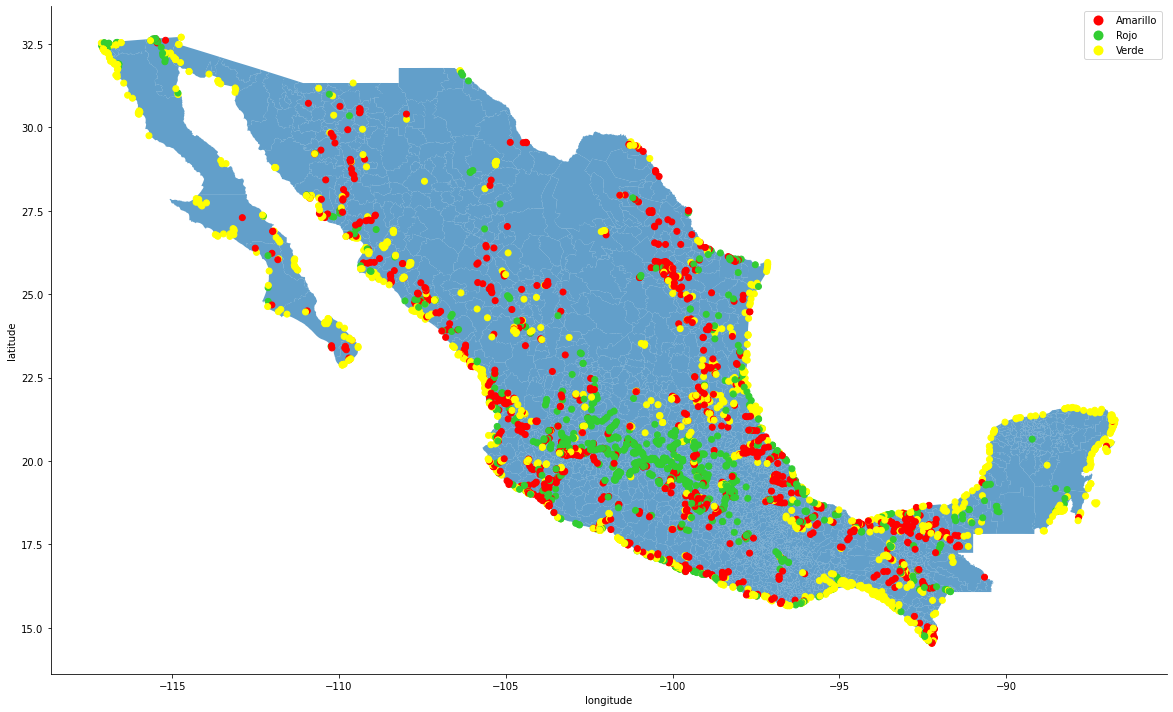

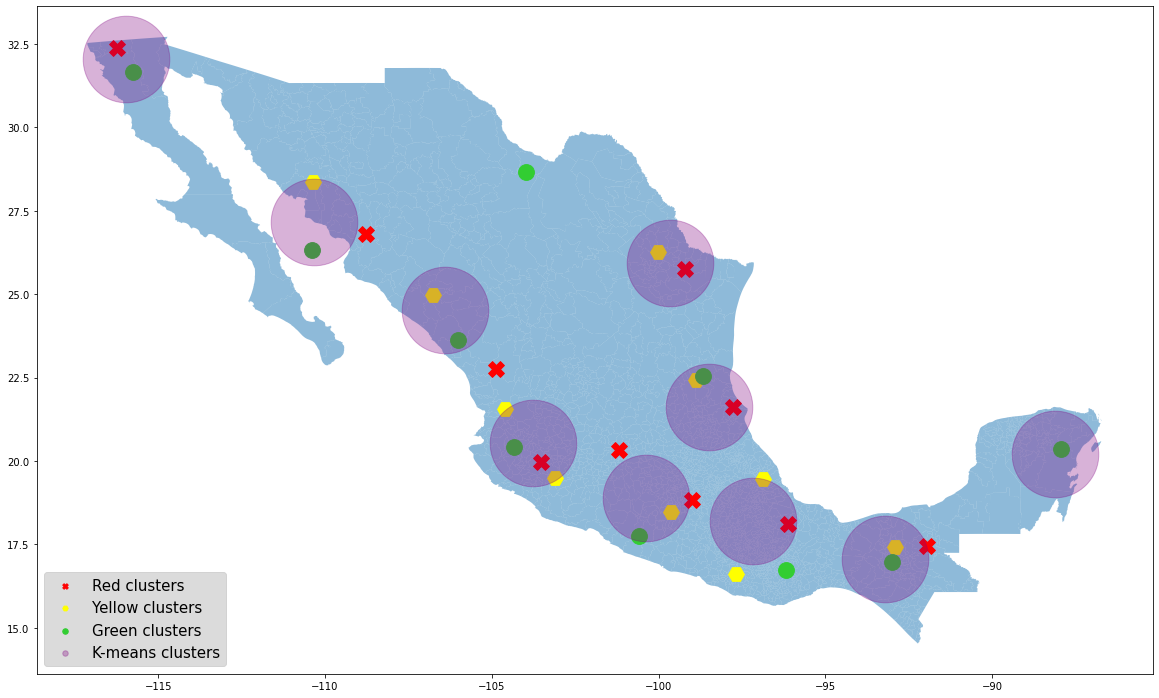

In [315]:
graphCuerposDeAgua(10, 7500, 10, 10, 10, superficialesLatLon)

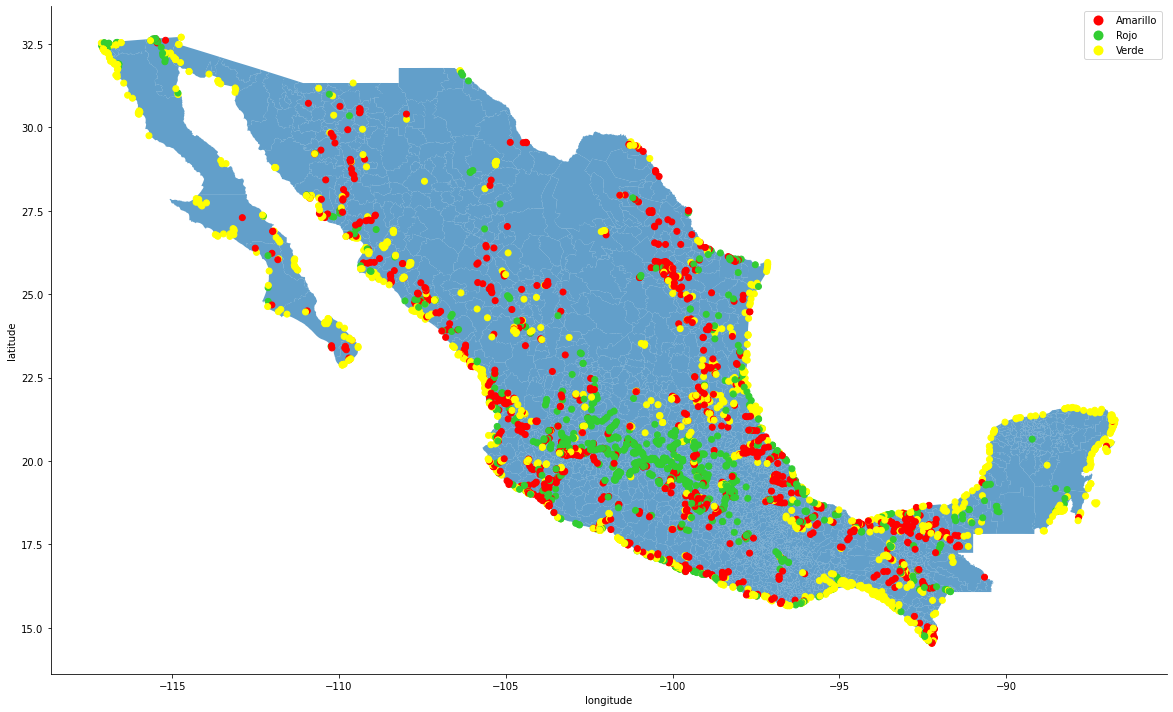

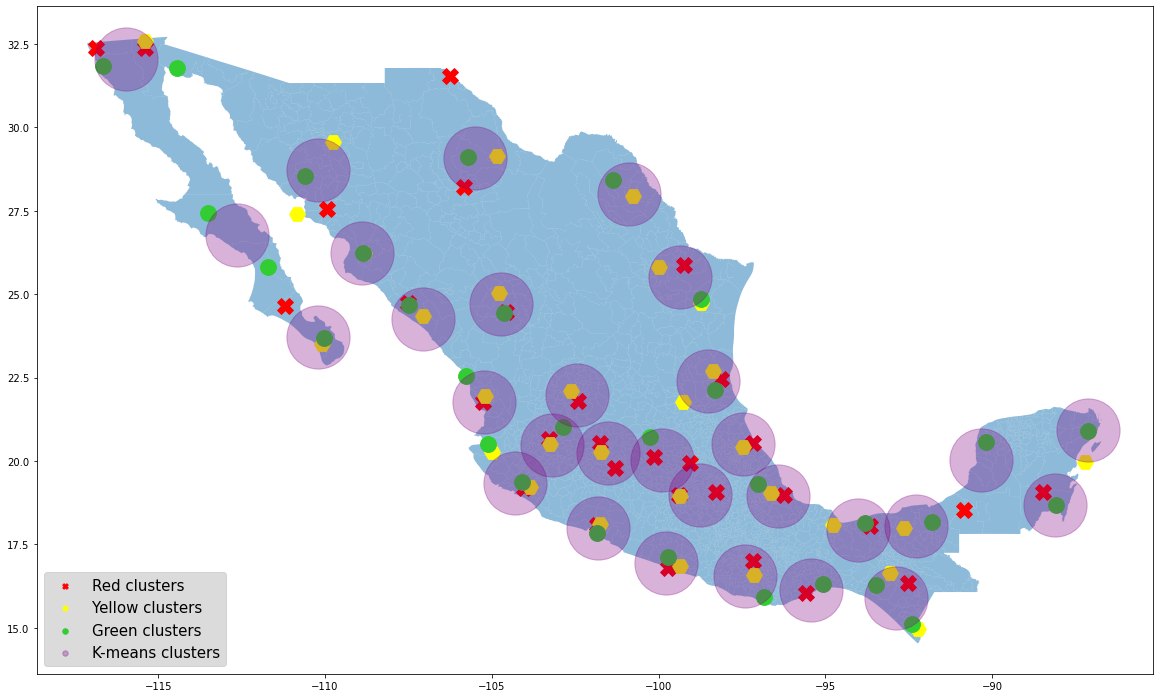

In [316]:
graphCuerposDeAgua(30, 4000, 30, 30, 30, superficialesLatLon)

In [280]:

def graphSilhouetteScoreInRange(lowerLimit,upperLimit,storesLatLon):
  range_n_clusters = range(lowerLimit,upperLimit)
  silhouette_avg = []
  for num_clusters in range_n_clusters:
  
    # initialise kmeans
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(storesLatLon)
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg.append(silhouette_score(storesLatLon, cluster_labels))

  plt.plot(range_n_clusters,silhouette_avg,'bx-')
  plt.xlabel('Values of K') 
  plt.ylabel('Silhouette score') 
  plt.title('Silhouette analysis For Optimal k')
  plt.show()

In [281]:
def graphElbowKmeansInRange(lowerLimit,upperLimit,storesLatLon):
  Sum_of_squared_distances = []
  K = range(lowerLimit,upperLimit)
  for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(storesLatLon)
    Sum_of_squared_distances.append(kmeans.inertia_)
  plt.plot(K,Sum_of_squared_distances,'bx-')
  plt.xlabel('Values of K') 
  plt.ylabel('Sum of squared distances/Inertia') 
  plt.title('Elbow Method For Optimal k')
  plt.show()

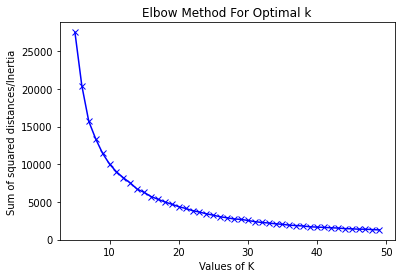

In [286]:
graphElbowKmeansInRange(5,50,superficialesLatLon[['LATITUD','LONGITUD']])

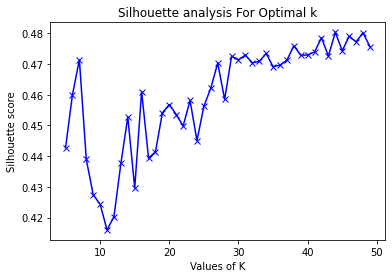

In [285]:
graphSilhouetteScoreInRange(5,50,superficialesLatLon[['LATITUD','LONGITUD']])